In [1]:
from orthofinder_utils import dash_ortho_parser as dop
from orthofinder_utils import itol_annotations as itol_annot
from jw_utils import parse_gff as pgf
from jw_utils import parse_fasta as pfa
import os
import pandas as pd
import json
from Bio import Phylo
import shutil
import plotly.graph_objects as go
from jw_utils import plotly_preferences as pprefs

In [2]:
rgb_to_hex = {'rgba(132,137,145,1)':'#848991',
 'rgb(0,208,132)':'#00d084',
 'rgb(0,122,255)':'#007aff',
 'rgb(171,184,195)':'#abb8c3',
 'rgb(255,105,0)':'#ff6900',
 'rgb(252,185,0)':'#fcb900',
 'rgb(123,220,181)':'#7bdcb5',
 'rgb(142,209,252)':'#8ed1fc',
 'rgb(6,147,227)':'#0693e3',
 'rgb(155,81,224)':'#9b51e0',
 'rgb(207,46,46)':'#cf2e2e',
 'rgb(247,141,167)':'#f78da7'}
diverging_colors = [
    # "#4E79A7", "#A0CBE8", "#F28E2B", "#FFBE7D", "#59A14F",
    # "#8CD17D", "#B6992D", "#FDCB9E", "#499894", "#86BCB6",
    "#E15759", "#FF9D9A", "#79706E", "#BAB0AC", "#D37295",
    "#FABFD2", "#B07AA1", "#D4A5A5", "#F7F7F7", "#CCCCCC",
    "#0072B2", "#009E73", "#D55E00", "#CC79A7", "#56B4E9",
    "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7",
    "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00",
    "#CC79A7", "#56B4E9", "#009E73", "#F0E442", "#0072B2",
    "#D55E00", "#CC79A7", "#56B4E9", "#009E73", "#F0E442",
    "#0072B2", "#D55E00", "#CC79A7", "#56B4E9", "#009E73"
]

hex_colors = list(rgb_to_hex.values())

In [3]:
dop_obj = dop.DashOrthoParser('./data',tax_level='N3')
dop_obj.accession_to_name['GCF_008632635.1']

'Acinetobacter baumannii K09-14'

In [4]:
def get_nearby_genes_in_cluster():
    """"""
    genes = []
    base = 'KZA74_0'
    p2g_d = pgf.make_gene2prot_dict('./data/ncbi_dataset/data/GCA_019356215.1/genomic.gff')
    cluster_proteins = []
    for i in range(9240,9410, 5):
        gene = base+str(i)
        genes.append(gene)
        cluster_proteins.append(p2g_d.get('gene-'+gene))
    prot_to_HOG_d_all = dop_obj.gene_HOG_dict('GCA_019356215.1')
    gene_to_HOG_d = {
        prot:prot_to_HOG_d_all.get(prot.strip('cds-')) for prot in cluster_proteins
        if prot_to_HOG_d_all.get(prot.strip('cds-'))
        }
    return gene_to_HOG_d
 

gene_to_HOG_d = get_nearby_genes_in_cluster()  
HOGs_to_gene_d = {v:k for k,v in gene_to_HOG_d.items()}

### Make itol annotation file for presence/absence of genes in cluster Accessory gene cluster 44 kb

In [5]:
tree = Phylo.read('./data/Species_Tree/SpeciesTree_rooted_node_labels.txt', format='newick')
HOG_list, binary_count_dict = itol_annot.make_binary_count_dict(tree, gene_to_HOG_d.values(), dop_obj)

In [6]:
name_list = [HOGs_to_gene_d[HOG] for HOG in HOG_list]
itol_annot.make_multi_itol_bargraph_dataset('./itol_dataset_multi.txt',binary_count_dict, name_list,hexcolors=diverging_colors)

In [7]:
relabel_dict = {acc:name.replace('Acinetobacter','A.') for acc, name in dop_obj.accession_to_name.items()}
itol_annot.relabel_itol_treeleafs(tree, relabel_dict, './itol_annotations_relabel.txt')

### make itol UN vs VU allele annotation file for genes of interest

In [8]:
LP_acc = dop_obj.name_to_accession['Acinetobacter baumannii ATCC 17978-mff']
gene_d = dop_obj.gene_HOG_dict(LP_acc)
gene_2_prot_d = pgf.make_gene2prot_dict(f'./data/ncbi_dataset/data/{LP_acc}/genomic.gff')
gene_ortho_d = {}


In [9]:
genes_to_check = {'ACX60_00950','ACX60_05080', 'ACX60_07925', 'ACX60_10365','ACX60_11495', 'ACX60_05695'}
#removed 'ACX60_05895' from genes_to_check
for gene in genes_to_check:
    prot = gene_2_prot_d['gene-'+gene]
    gene_ortho_d[gene] = gene_d[prot.strip('cds-')]   
gene_ortho_d

{'ACX60_05080': 'N3.HOG0002063',
 'ACX60_00950': 'N3.HOG0000757',
 'ACX60_11495': 'N3.HOG0003331',
 'ACX60_07925': 'N3.HOG0001797',
 'ACX60_10365': 'N3.HOG0001220',
 'ACX60_05695': 'N3.HOG0001748'}

In [10]:
def make_fasta_files(gene_ortho_d, output_dir):
    """"""
    if not os.path.exists(output_dir):  
        os.makedirs(output_dir)   
    for HOG in gene_ortho_d.values():
        fasta_d = dop_obj.get_HOG_protein_seqs(HOG)['Protein_seq'].to_dict()
        pfa.write_to_fasta(fasta_d,f'{output_dir}/{HOG}.faa')
output_dir  = './UN_vs_VU_variants/fasta_files'
make_fasta_files(gene_ortho_d=gene_ortho_d, output_dir= output_dir)

### Align protein seqs from each HOG of interest with muscle

bash script for running muscle on all .faa file in dir  
`$ cd dir/with/fastas`  
```
for file in ./*.faa;  
    do    
    base="${file%.faa}"  
    out_file=${base}.afa   
    echo $out_file   
    muscle -align $file -output $out_file;   
    done
```

In [11]:
def make_HOG_protein_align_files(gene_ortho_d, output_dir):
    if not os.path.exists(output_dir):  
        os.makedirs(output_dir)
    for HOG in gene_ortho_d.values():
        df = dop_obj.get_HOG_protein_seqs(HOG)
        d = {prot_id:seq for prot_id,seq in zip(df.index, df['Protein_seq'])}
        pfa.write_to_fasta(d,f'{output_dir}/{HOG}.faa')
        input_file = f'{output_dir}/{HOG}.faa'
        output_file = input_file.replace('faa', 'afa')
        !muscle -in $input_file -out $output_file 

#make_HOG_protein_align_files(gene_ortho_d=gene_ortho_d, output_dir=output_dir)

In [12]:
gene_var_d = {
 'ACX60_00950': {'VU':'A382', 'UN':'T382'},
 'ACX60_07925': {'VU':'M78', 'UN':'T78'},
 'ACX60_05695': {'VU':'G12', 'UN':'D12'},
 'ACX60_11495': {'VU':'T2', 'UN':'K2'},
 'ACX60_05080': {'VU':'N258', 'UN':'I258'},
 'ACX60_10365': {'VU':'F806', 'UN':'V806'}, ## gaps in alignment unaligned 17978-mff = position 799
}

#################################################################################### 
# 1 means VU variant,0 means UN variant, -1 means neither variant or absent altogether
####################################################################################
all_leafnames = [cl.name for cl in tree.get_terminals()]
variants_tally  = {}
d_nested = {gene:{} for gene in gene_ortho_d}
count_d = {gene:{} for gene in gene_var_d}
for gene, HOG in gene_ortho_d.items():
    VU_var = gene_var_d[gene]['VU']
    UN_var = gene_var_d[gene]['UN']
    d = pfa.get_seq_dict(f'./UN_vs_VU_variants/fasta_files/{HOG}.afa')
    VU_tally = 0 
    UN_tally = 0 
    other_tally = 0
    acc_prot_d = {p[:15][::-1].replace('_','.',1)[::-1]:p[16:] for p in list(d.keys())}
    #for protein in d:
    for acc in all_leafnames:
        if not acc_prot_d.get(acc):
            acc = acc[:-2] +'_' + acc[-1]
            count_d[gene][acc] = -1
        else:
            protein =  acc[::-1].replace('.','_',1)[::-1]+'_'+ acc_prot_d[acc]
            pos =  int(VU_var[1:])-1
            var = d[protein][pos]
            #print(gene, var, 'UN',UN_var[0], 'VU', VU_var[0])
            if var == VU_var[0]:
                VU_tally +=1
                count_d[gene][protein] = 1
            elif var ==  UN_var[0]:
                UN_tally +=1
                count_d[gene][protein] = 0
            else:
                #print(HOG,protein, var)
                other_tally += 1
                count_d[gene][protein] = -1
            
    variants_tally[gene] = {'VU':VU_tally, 'UN': UN_tally, 'Other': other_tally}
variants_tally

{'ACX60_05080': {'VU': 227, 'UN': 1, 'Other': 0},
 'ACX60_00950': {'VU': 229, 'UN': 1, 'Other': 0},
 'ACX60_11495': {'VU': 184, 'UN': 1, 'Other': 0},
 'ACX60_07925': {'VU': 228, 'UN': 1, 'Other': 0},
 'ACX60_10365': {'VU': 2, 'UN': 228, 'Other': 0},
 'ACX60_05695': {'VU': 204, 'UN': 1, 'Other': 24}}

In [13]:
def add_clsC2_to_dict():
    """"""
    count_d['clsC2'] = {}
    clsC2_prots = dop_obj.all_prots_in_HOG('N3.HOG0003090')
    for acc in all_leafnames:
        acc = acc[::-1].replace('.','_',1)[::-1]
        count_d['clsC2'][acc] = 0 
    for acc in all_leafnames:
        for prot in clsC2_prots:
            if prot.startswith(acc[:13]):
                acc = acc[::-1].replace('.','_',1)[::-1]
                count_d['clsC2'][acc] = 1
    return count_d
count_d = add_clsC2_to_dict()

In [69]:

def flatten_nested(nested_d):
    """"""
    name_list = []
    flattened_d = {acc:[] for acc in [cl.name for cl in tree.get_terminals()]}
    for name, d in nested_d.items():
        name_list.append(name)
        for leaf, count in d.items():
            leaf = leaf[:15][::-1].replace('_','.',1)[::-1]
            flattened_d[leaf].append(count)
    return flattened_d, name_list
        

#######################
# change 0 to -1 in 'ACX60_05695', as there is only one UN variant, 
# we will change all empyty boxes to black or something to denote 'other'

#######
for acc in count_d['ACX60_05695']:
    if count_d['ACX60_05695'][acc] == -1:
        count_d['ACX60_05695'][acc] = 0
for acc in count_d['ACX60_05080']:
    if count_d['ACX60_05080'][acc] == -1:
        count_d['ACX60_05080'][acc] = 1

flattened_d, name_list = flatten_nested(count_d)
strain_data_counts_df.columns

Index(['ACX60_00950', 'ACX60_07925', 'ACX60_05695', 'ACX60_11495',
       'ACX60_05080', 'ACX60_10365', 'clsC2', 'strain_name'],
      dtype='object')

In [84]:
strain_data_counts_df = pd.DataFrame(flattened_d).transpose()
strain_data_counts_df.columns = name_list
names  = []
for acc in strain_data_counts_df.index:
    names.append(dop_obj.accession_to_name[acc])
strain_data_counts_df['strain_name'] = names
strain_data_counts_df = strain_data_counts_df[['strain_name','ACX60_00950', 'ACX60_07925', 'ACX60_05695', 'ACX60_11495','ACX60_05080', 'ACX60_10365', 'clsC2']]
strain_data_counts_df.to_csv('./UN_vs_VU_variants/summary_data/strain_data_counts.csv')

In [15]:
colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#17becf"   # Cyan
]


itol_annot.make_itol_binary_trait_dataset(
            outfile_path = './UN_vs_VU_variants/itol_annotations/itol_binary_traits.txt', 
            count_dict = flattened_d, 
            name_list = list(count_d.keys()),
            hexcolors=colors)

In [51]:
import plotly.graph_objects as go
import pandas as pd

# dictionary
variants_tally['ClsC2'] = {'VU': 22, 'UN': 207}
# Convert dictionary to a DataFrame
df = pd.DataFrame(variants_tally).T

# Calculate percentages
total_species=229
df_percent = df.div(total_species) * 100

# Create a stacked bar graph using plotly.graph_objects
fig = go.Figure()

for col in df_percent.columns:
    fig.add_trace(go.Bar(
        x=df_percent.index,
        y=df_percent[col],
        name=col
    ))

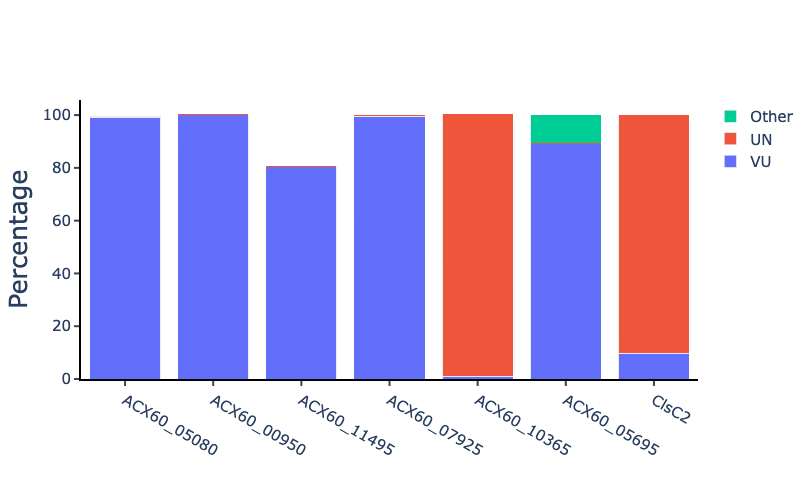

In [36]:
from jw_utils import plotly_preferences as pprefs

layout = pprefs.bargraph_layout(title='',
    x_title='',
    y_title='Percentage',
    height=500,
    width=600,
    plot_bgcolor='rgb(255,255,255)',
    legend_fontsize=15,
    yaxis_fontsize=25,
    xaxis_fontsize=25,
)
fig.update_layout(layout)

In [38]:
import plotly.io as pio
pio.write_image(fig, "./UN_vs_VU_variants/variant_figure/UNvsVU_percentages.svg")

In [46]:
df = df.fillna(0)
df = df.astype(int)
df.to_csv('./UN_vs_VU_variants/summary_data/summary_data.csv')
df

,VU,UN,Other
ACX60_05080,227,1,0
ACX60_00950,229,1,0
ACX60_11495,184,1,0
ACX60_07925,228,1,0
ACX60_10365,2,228,0
ACX60_05695,204,1,24
ClsC2,22,207,0
